In [1]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip install dcor dtaidistance

     |████████████████████████████████| 327kB 19.1MB/s 
  Created wheel for dtaidistance: filename=dtaidistance-1.2.3-cp36-cp36m-linux_x86_64.whl size=631120 sha256=b8d3cd14d00c12ff7466926836a8dc53d21899cf42e4453341505dd17a328901
  Stored in directory: /root/.cache/pip/wheels/9f/9a/74/42c5b9dc714bb5a70b426df08cc860e6a741bc199004873e1b
Successfully built dtaidistance


In [0]:
import os
import h5py
import time
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import dcor
from dtaidistance import dtw

from sklearn.metrics import confusion_matrix, classification_report

In [0]:
with h5py.File(os.path.join(root_path, 'mitdb', 'all_ecg.hdf5'), 'r') as hdf:
    x = hdf['x'][:]
    y = hdf['y'][:]

In [5]:
random.seed(2019)
x = np.array(random.choices(x, k=10000))
print(x.shape)
print(y.shape)

(10000, 1, 128)
(96049,)


In [0]:
class AvgDownSampler(nn.Module):
    def __init__(self):
        super(AvgDownSampler, self).__init__()
        self.pool = nn.AvgPool1d(4)

    def forward(self, x):
        x = self.pool(x)
        return x.data.numpy().squeeze()

In [0]:
avg_sampler = AvgDownSampler()

In [0]:
class EcgConv6(nn.Module):
    def __init__(self):
        super(EcgConv6, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, 7, padding=3)  # 128 x 16        
        self.relu1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool1d(2)  # 64 x 16
        self.conv2 = nn.Conv1d(16, 16, 5, padding=2)  # 64 x 16
        self.relu2 = nn.LeakyReLU()        
        self.conv3 = nn.Conv1d(16, 16, 5, padding=2)  # 64 x 16
        self.relu3 = nn.LeakyReLU()        
        self.conv4 = nn.Conv1d(16, 16, 5, padding=2)  # 64 x 16
        self.relu4 = nn.LeakyReLU()
        self.conv5 = nn.Conv1d(16, 16, 5, padding=2)  # 64 x 16
        self.relu5 = nn.LeakyReLU()
        self.conv6 = nn.Conv1d(16, 16, 5, padding=2)  # 64 x 16
        self.relu6 = nn.LeakyReLU()
        self.pool6 = nn.MaxPool1d(2)  # 32 x 16
        self.linear7 = nn.Linear(32 * 16, 128)
        self.relu7 = nn.LeakyReLU()
        self.linear8 = nn.Linear(128, 5)
        self.softmax8 = nn.Softmax(dim=1)
     
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.conv6(x)
        x = self.relu6(x)
        x = self.pool6(x)
        return x.data.numpy().squeeze()

In [9]:
ecg_conv6 = EcgConv6()
ecg_conv6.load_state_dict(torch.load(os.path.join(root_path, 'model', 'conv6_3_100.pth'), map_location=torch.device('cpu'))) # conv6_3_best.pth
ecg_conv6.eval()

EcgConv6(
  (conv1): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu2): LeakyReLU(negative_slope=0.01)
  (conv3): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu3): LeakyReLU(negative_slope=0.01)
  (conv4): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu4): LeakyReLU(negative_slope=0.01)
  (conv5): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu5): LeakyReLU(negative_slope=0.01)
  (conv6): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu6): LeakyReLU(negative_slope=0.01)
  (pool6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear7): Linear(in_features=512, out_features=128, bias=True)
  (relu7): LeakyReLU(negative_slope=0.01)
  (linear8): Linear(in_features=1

In [10]:
dtw_list = [list() for i in range(16)]
dcor_avg_sample = [list() for i in range(16)]
dcor_max_sample = [list() for i in range(16)]

for x_sample in tqdm(x):
    x_tensor = torch.tensor(np.expand_dims(x_sample, axis=0), dtype=torch.float)
    output = ecg_conv6(x_tensor)
    x_avgdown = avg_sampler(x_tensor)
    for i, o in enumerate(output):
        dtw_val = dtw.distance_fast(x_sample.squeeze().astype(np.double), o.astype(np.double))
        dtw_list[i].append(dtw_val)
        dcor_val = dcor.distance_correlation(x_avgdown, o)
        dcor_avg_sample[i].append(dcor_val)

100%|██████████| 10000/10000 [03:52<00:00, 42.99it/s]


In [11]:
np.array(dtw_list).shape

(16, 10000)

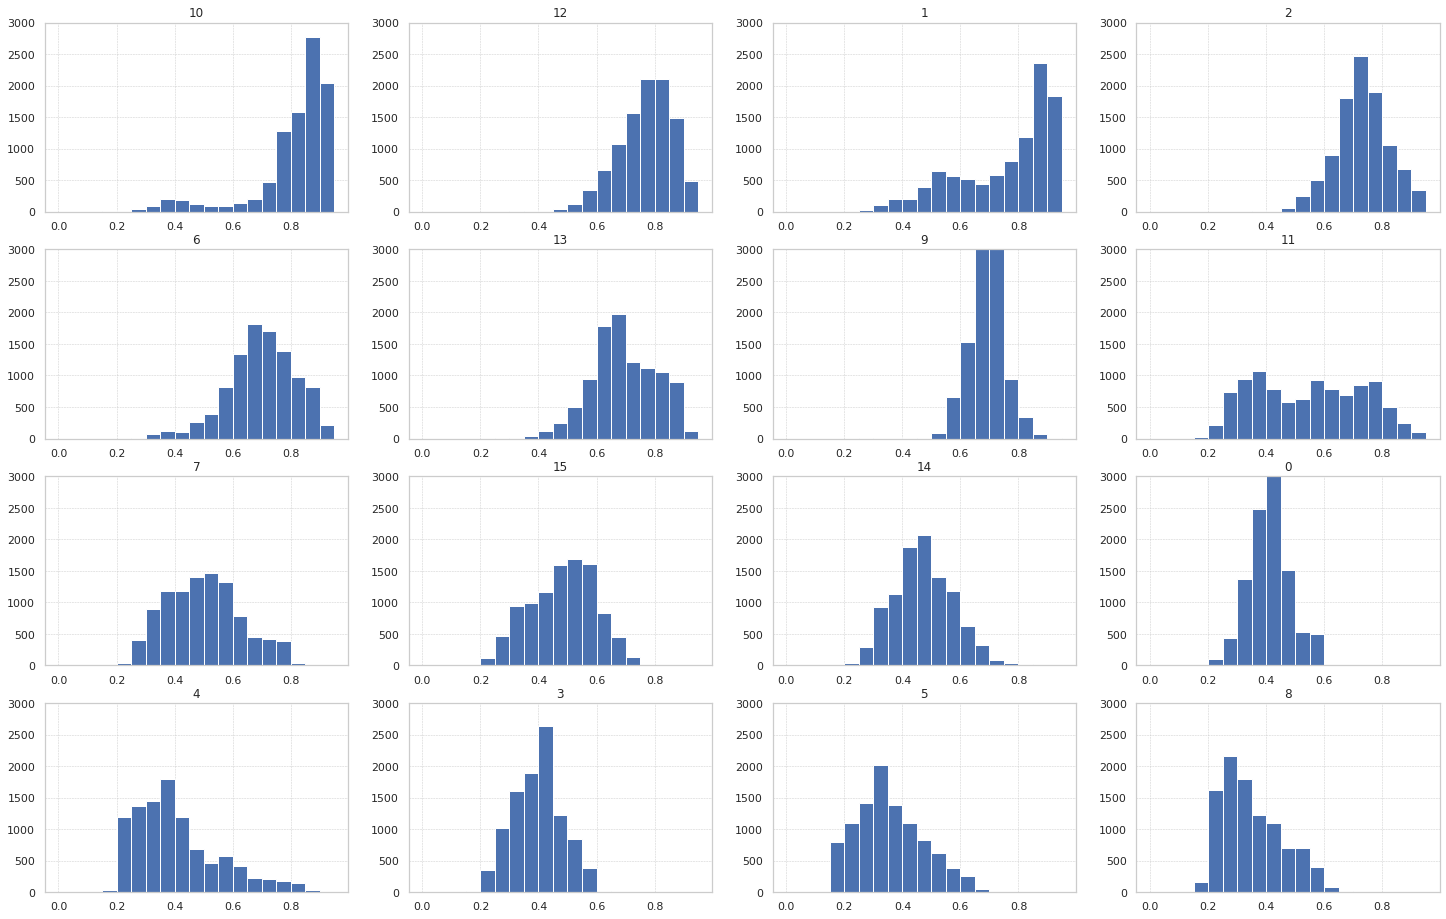

In [12]:
sns.set(style='whitegrid', rc={"grid.linewidth": 0.5, 'grid.linestyle': '--'})
dcor_avg_sample = np.array(dcor_avg_sample)
idx = np.argsort(np.mean(dcor_avg_sample, axis=1))[::-1]
dcor_avg_sample = dcor_avg_sample[idx]
fig, ax = plt.subplots(4, 4, figsize=(25, 16))
for i in range(16):
    a = ax[i//4][i%4]
    a.set_ylim(0, 3000)
    a.set_title(idx[i])
    a.hist(dcor_avg_sample[i], bins=[0.05 * i for i in range(20)])
np.savetxt(os.path.join(root_path, 'dtw_dcor', 'conv6_dcor.csv'), dcor_avg_sample, delimiter=",", fmt='%.4f')
np.savetxt(os.path.join(root_path, 'dtw_dcor', 'conv6_dcor_mean.csv'), np.mean(dcor_avg_sample, axis=1), delimiter=",", fmt='%.4f')

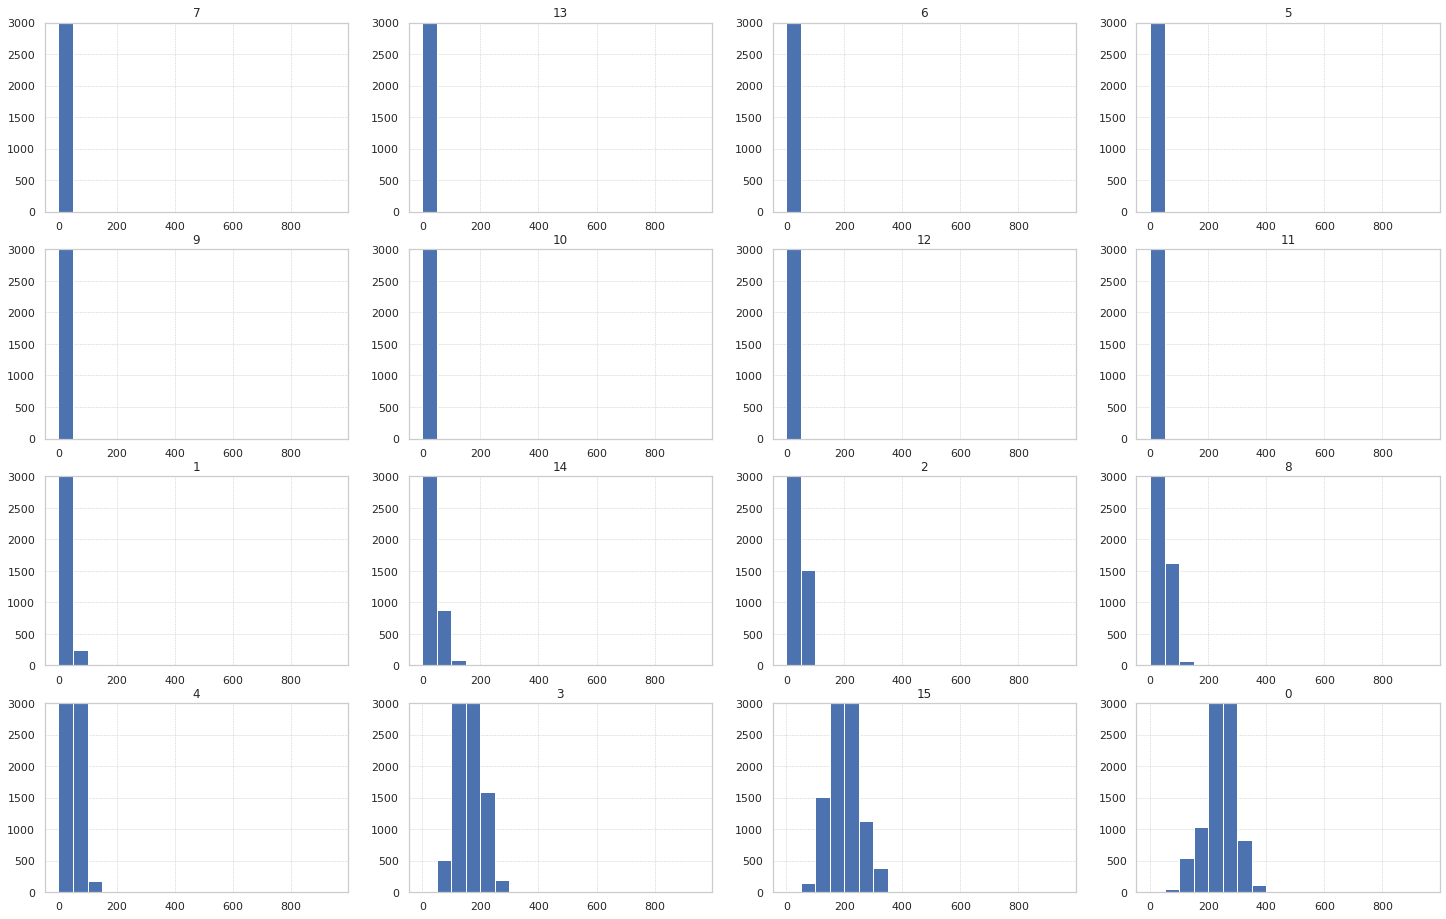

In [13]:
dtw_list = np.array(dtw_list)
idx = np.argsort(np.mean(dtw_list, axis=1))
dtw_list = dtw_list[idx]
fig, ax = plt.subplots(4, 4, figsize=(25, 16))
for i in range(16):
    a = ax[i//4][i%4]
    a.set_ylim(0, 3000)
    a.set_title(idx[i])
    a.hist(dtw_list[i], bins=[50 * i for i in range(20)])
np.savetxt(os.path.join(root_path, 'dtw_dcor', 'conv6_dtw.csv'), dtw_list, delimiter=",", fmt='%.4f')
np.savetxt(os.path.join(root_path, 'dtw_dcor', 'conv6_dtw_mean.csv'), np.mean(dtw_list, axis=1), delimiter=",", fmt='%.4f')